In [1]:
from shapely.geometry import Polygon
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def list_to_coord(x):
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    
    x = [[x0, x2], [x1, x2], [x1, x3], [x0, x3]]
    return x

def calculate_iou(box_1, box_2):
    box_1 = list_to_coord(box_1)
    box_2 = list_to_coord(box_2)
    
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

def convert(x, label=True):
    x_min = int((float(x[1])-(float(x[3])/2))*640)
    x_max = int((float(x[1])+(float(x[3])/2))*640)

    y_min = int((float(x[2])-(float(x[4])/2))*640)
    y_max = int((float(x[2])+(float(x[4])/2))*640)
    
    if not label:
        return x_min, x_max, y_min, y_max
    else:
        return x_min, x_max, y_min, y_max, int(x[0])
    
def calculate_area(prediction):
    return (prediction[1] - prediction[0] + 1) * (prediction[3] - prediction[2] + 1)

In [2]:
def test_iou(save_area=False):
    collect_true = []
    collect_predicted = []


    for txt in sorted(os.listdir('runs/detect/exp14/labels/')):
        with open('our_picture/test/labels/' + txt) as f:
            true_labels = list(map(lambda x: x[:-2].split(), f.readlines()))
        with open('runs/detect/exp14/labels/' + txt) as t:
            predicted_labels = list(map(lambda x: x[:-2].split(), t.readlines()))

        correct_ious = []

        for true in true_labels:
            for predict in predicted_labels:
                    correct_ious.append([calculate_iou(convert(true), convert(predict)), 
                                         true[0], 
                                         predict[-1],
                                         txt
                                         ] + list(convert(true, label=False)) + list(convert(predict, label=False)))
                
    return correct_ious

In [3]:
ious = pd.DataFrame(test_iou(), columns=['iou', 'label', 'confidence', 'image', 
                                         'xmin_true', 'xmax_true','ymin_true', 'ymax_true',
                                        'xmin_pred', 'xmax_pred','ymin_pred', 'ymax_pred',])   
ious['confidence'] = ious['confidence'].astype(float)

ious.head()

,iou,label,confidence,image,xmin_true,xmax_true,ymin_true,ymax_true,xmin_pred,xmax_pred,ymin_pred,ymax_pred
0,0.0,2,0.86743,IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c...,293,321,410,433,118,182,194,308
1,0.0,2,0.92063,IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c...,293,321,410,433,407,516,197,291
2,0.0,0,0.86743,IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c...,527,555,515,532,118,182,194,308
3,0.0,0,0.92063,IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c...,527,555,515,532,407,516,197,291
4,0.0,0,0.86743,IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c...,130,147,562,583,118,182,194,308


In [4]:
set(ious['image'])

{'IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c1a5.txt'}

In [5]:
trues = []
predicts = []
for i in ious.itertuples():
    if [i.xmin_true, i.xmax_true, i.ymin_true, i.ymax_true] not in trues:
        trues.append([i.xmin_true, i.xmax_true, i.ymin_true, i.ymax_true])
    if [i.xmin_pred, i.xmax_pred, i.ymin_pred, i.ymax_pred] not in predicts:
        predicts.append([i.xmin_pred, i.xmax_pred, i.ymin_pred, i.ymax_pred])
    


In [6]:
trues

[[293, 321, 410, 433],
 [527, 555, 515, 532],
 [130, 147, 562, 583],
 [161, 177, 94, 116],
 [406, 515, 197, 286],
 [117, 180, 202, 299],
 [320, 342, 335, 358],
 [262, 281, 338, 356]]

## Analyze Results - Low Confidence vs High Confidence

our_picture/test/images/IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c1a5.jpg


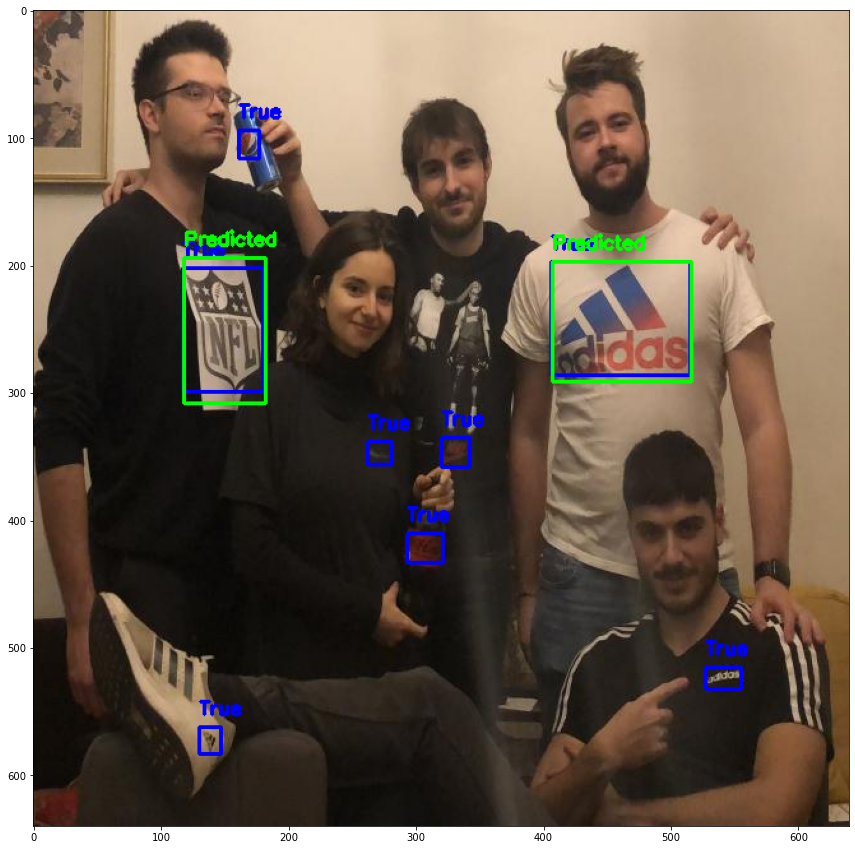

In [18]:
import cv2 

    
plt.figure(figsize=(15, 15))


path = 'our_picture/test/images/IMG_6711_jpeg.rf.3d97a8966785545ca20868f12a35c1a5.' + 'jpg'

print(path)

image = cv2.imread(path, -1) 

# Blue color in BGR 
color1 = (255, 0, 0) 
color2 = (0, 255, 0)

# Line thickness of 2 px 
thickness = 2


# Using cv2.rectangle() method 
# Draw a rectangle with blue line borders of thickness of 2 px 

for true in trues:
    cv2.rectangle(image, (true[0], true[2]), (true[1], true[3]), color1, thickness) 
    cv2.putText(image, 'True', (true[0], true[2]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color1 , 2)

for pred in predicts:
    cv2.rectangle(image, (pred[0], pred[2]), (pred[1], pred[3]), color2, thickness)
    cv2.putText(image, 'Predicted', (pred[0], pred[2]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color2, 2)

plt.imshow(image[...,::-1])

plt.grid(False)
plt.savefig('our_picture.png')